# Permutation Importance

변수의 값을 무작위로 변경하여 모델 성능을 평가하여, 해당 변수가 모델에 영향을 미치는 정도를 측정하기 위한 순열 중요도 측정.

---

## 목표

- 변수가 모델에 영향을 미치는 정도를 측정

## 로드/전처리/피처 정합성

- DATA_PATH는 현재 사용하는 labeled 더미 CSV
- preprocess_pipeline()로 전처리
- FEATURE_COLS 기준으로 X 생성
- y는 at_risk(또는 현재 라벨 컬럼)

In [ ]:
import sys
from pathlib import Path
import joblib
import pandas as pd

sys.path.insert(0, str(Path.cwd().parent))
from backend.src.preprocessing import load_csv, preprocess_pipeline

PROJECT_ROOT = Path("..").resolve()  # notebook 폴더 기준이면 보통 .. 이 루트
DATA_PATH = PROJECT_ROOT / "data/dummy/dummy_midterm_like_labeled.csv"


# 1) load + preprocess
df_raw = load_csv(str(DATA_PATH))
df = preprocess_pipeline(df_raw)

## 모델 로드

- models/logistic_model.joblib 로드
- model.predict_proba(X)[:,1] 동작 확인

In [ ]:
from backend.src.config import FEATURE_COLS

# 2) X, y
X = df[FEATURE_COLS].copy()
y = df["at_risk"].astype(int)  # 라벨 컬럼명이 다르면 여기만 수정

MODEL_PATH = PROJECT_ROOT / "models/logistic_model.joblib"

# 3) model load
model = joblib.load(MODEL_PATH)

## Permutation Importance 계산

- sklearn.inspection.permutation_importance 사용
- 분류 문제이므로 scoring은 보통 아래 중 하나:
  - roc_auc (확률 예측 품질)
  - f1 (임계값 기반)
  - average_precision(불균형 고려)

In [ ]:
from sklearn.inspection import permutation_importance

OUT_TABLE = PROJECT_ROOT / "reports/tables/permutation_importance.csv"
OUT_TABLE.parent.mkdir(parents=True, exist_ok=True)

# 4) permutation importance
r = permutation_importance(
    model,
    X,
    y,
    n_repeats=20,
    random_state=42,
    scoring="roc_auc",
)

imp = pd.DataFrame({
    "feature": X.columns,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std,
}).sort_values("importance_mean", ascending=False)

imp.to_csv(OUT_TABLE, index=False, encoding="utf-8-sig")
imp.head(15)

,feature,importance_mean,importance_std
9,absence_count,0.053572,0.015069
11,participation_level_num,0.032944,0.008396
10,behavior_score,0.022289,0.005770
0,midterm_score,0.020199,0.007072
8,night_study,0.004475,0.002723
7,question_count,0.004396,0.004311
6,assignment_count,0.001847,0.002257
1,final_score,0.000000,0.000000
4,final_score_missing,0.000000,0.000000
3,midterm_score_missing,0.000000,0.000000


## 시각화 + 저장

- 중요도 평균 기준 내림차순
- 상위 N개(예: 10개) 막대그래프
- 표/그림 파일 저장

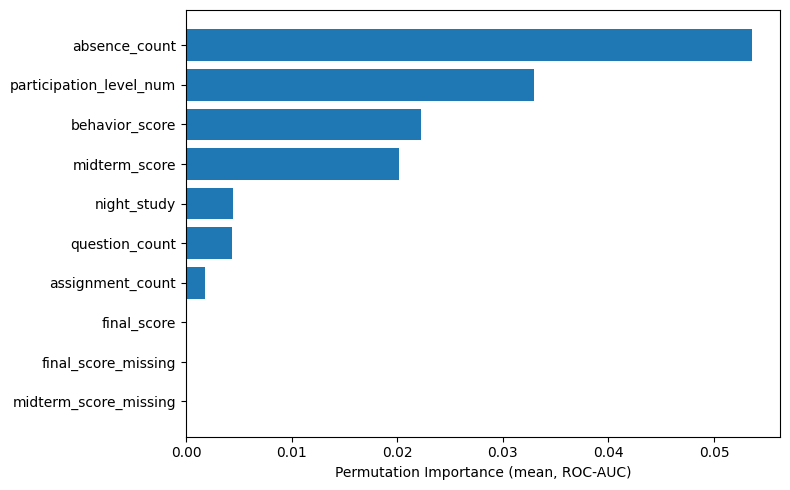

In [ ]:
import matplotlib.pyplot as plt

OUT_FIG = PROJECT_ROOT / "reports/figures/permutation_importance_bar.png"
OUT_FIG.parent.mkdir(parents=True, exist_ok=True)

# 5) plot
top_n = 10
plot_df = imp.head(top_n).iloc[::-1]  # 보기 좋게 역순

plt.figure(figsize=(8, 5))
plt.barh(plot_df["feature"], plot_df["importance_mean"])
plt.xlabel("Permutation Importance (mean, ROC-AUC)")
plt.tight_layout()
plt.savefig(OUT_FIG, dpi=150)
plt.show()